# COGS 108 - Final Project 

# Overview

This project seeks to investigate whether or not a game's genre and score can be used to predict whether or not a game is going to be popular, which is measured by the number of sales for a game. By building a model with a linear SVM, we were able to correctly predict whether or not a game is popular with an accuracy of 66%. Therefore, we conclude that a game's genre and critic score is a potentially useful metric to predict a game's popularity.

# Names

- Kyle Huang
- Derek Tse
- Zhaoge Ouyang
- Cary Wang

# Research Question

Can a game's genre and score predict the popularity of a game (based on the number of sales)?

## Background and Prior Work

This question is interesting because:
- We will be able to see the current trends in gaming.
- Recent games such as Among Us and Genshin Impact have skyrocketed in popularity and sales, so we want to investigate what characteristics allow these games to become popular. 
- The study done by "British Journal of Educational Technology"(the first reference link) on twenty students suggests that genre influences the popularity of the game, as the students preferred to play strategy or 3D adventure games than game genres like shoot-em-up.
- At the same time, Kaggle (the second reference link) has effectively provided us with an EDA that links between the genre, region, and platform together.

References (include links):
- 1) https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.549.6080&rep=rep1&type=pdf
- 2) https://www.kaggle.com/gulsahdemiryurek/video-game-sales-exploratory-data-analysis

# Hypothesis


Our hypothesis is that games that fall into the adventure and strategy genres tend to have the highest sales (and therefore popularity) due to games in the two genres having more sales and higher critic scores. In other words, game genre and score (both user and critic) should have an effect on the popularity of a game. When we think about most popular console game series such as Pokemon or Legend of Zelda, these game series both fall into the adventure genre, and these are also usually most highly acclaimed by critics and users alike.

# Datasets

- Dataset Name: Video Game Sales
- Link to the dataset: https://www.kaggle.com/gregorut/videogamesales
- Number of observations: 16598

According to the dataset description, this dataset encompasses sales data for video games that had greater than 100,000 copies sold. The dataset gives us sales data for US, Europe, Japan, and then rest of the world (in millions). The dataset is sorted by total sales, in decreasing order.

- Dataset Name: Metacritic Games Stats 2011-2019
- Link to the dataset: https://www.kaggle.com/skateddu/metacritic-games-stats-20112019
- Number of observations: 4018

The dataset description tells us that this dataset contains statistics of video games from Metacritic, concerning games from 2011-2019. For this dataset, the columns that we are interested in are critic scores (aka metascore) and user scores of a video game. These are average ratings of a video game based on user and critic feedback. We will merge this dataset with the above dataset by matching them by video game name.

# Setup

Let's begin by importing some packages for analysis.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import SVC
from sklearn.metrics import classification_report, precision_recall_fscore_support
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)

In [2]:
# Configure libraries
# The seaborn library makes plots look nicer
sns.set()
sns.set_context('talk')

# Don't display too many rows/cols of DataFrames
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8

# Round decimals when displaying DataFrames
pd.set_option('precision', 2)

Let's import the dataset listed for the analysis.

In [3]:
vgsales = pd.read_csv('vgsales.csv')
metacritic = pd.read_csv('metacritic_games.csv')

To make sure that our data is imported properly:

In [4]:
vgsales.shape

(16598, 11)

In [5]:
vgsales.head()

,Rank,Name,Platform,Year,...,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,...,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,...,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,...,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,...,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,...,8.89,10.22,1.00,31.37


In [6]:
vgsales.columns

Index(['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'],
      dtype='object')

In [7]:
metacritic.shape

(5699, 15)

In [8]:
metacritic.head()

,game,platform,developer,genre,...,neutral_users,negative_users,metascore,user_score
0,Portal 2,PC,Valve Software,Action,...,107,19,95,90
1,The Elder Scrolls V: Skyrim,PC,Bethesda Game Studios,Role-Playing,...,322,451,94,82
2,The Legend of Zelda: Ocarina of Time 3D,3DS,GREZZO,Miscellaneous,...,20,5,94,90
3,Batman: Arkham City,PC,Rocksteady Studios,Action Adventure,...,34,27,91,87
4,Super Mario 3D Land,3DS,Nintendo,Action,...,39,11,90,84


In [9]:
metacritic.columns

Index(['game', 'platform', 'developer', 'genre', 'number_players', 'rating',
       'release_date', 'positive_critics', 'neutral_critics',
       'negative_critics', 'positive_users', 'neutral_users', 'negative_users',
       'metascore', 'user_score'],
      dtype='object')

Merge the critic scores with the sales data.

In [10]:
vgsales = metacritic.merge(vgsales, left_on='game', right_on='Name')

# Data Cleaning

<h3>Picking out the relevant columns:</h3>

In [11]:
vgsales.columns

Index(['game', 'platform', 'developer', 'genre', 'number_players', 'rating',
       'release_date', 'positive_critics', 'neutral_critics',
       'negative_critics', 'positive_users', 'neutral_users', 'negative_users',
       'metascore', 'user_score', 'Rank', 'Name', 'Platform', 'Year', 'Genre',
       'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales',
       'Global_Sales'],
      dtype='object')

The column labels are not clear, so we'll rename some of them. In the Kaggle page, sales are in units of millions. We will also not make use of the release year and the rank (we'll create our own ranks). Since we are only interested in the critic and user scores from the Metacritic data, we will not use the rest. We might not need name, but we'll keep it for now.

In [12]:
vgsales = vgsales.drop(['Year', 'Rank', 'Publisher', 'release_date', 'platform', 'genre', 'rating', 'number_players', 'positive_critics', 'negative_critics', 'neutral_critics', 'positive_users', 'neutral_users', 'negative_users'], axis=1)
vgsales = vgsales.rename(columns=str.lower)
vgsales = vgsales.rename(columns={'na_sales' : 'na_sales_million', 'eu_sales': 'eu_sales_million', 'jp_sales': 'jp_sales_million', 'other_sales': 'other_sales_million', 'global_sales': 'global_sales_million'})

Let's take a look at the platforms available. We won't use all of them for analysis (namely, we only use platforms that are released 2005 or later). We will store the platforms we will look at in the variable `platforms`.

In [13]:
vgsales['platform'].unique()

array(['X360', 'PS3', 'PC', 'WiiU', '3DS', 'PSP', 'PSV', 'PS4', 'XOne',
       'Wii', 'DS', 'PS2', 'GEN', 'XB', 'GC', 'PS', 'SAT', 'SNES', '2600',
       'GBA', 'N64'], dtype=object)

In [14]:
platforms = ['PC', 'DS', 'Wii', 'WiiU', '3DS', 'PS3', 'PS4', 'PSV', 'XB', 'X360', 'XOne']

We will only be considering the above platforms because the rest is way too outdated, and we will drop the outdated ones.

In [15]:
vgsales['platform'] = vgsales['platform'].apply(lambda x: x if x in platforms else np.nan)
vgsales.dropna(subset=['platform'], inplace=True)

In [16]:
vgsales['platform'].unique()

array(['X360', 'PS3', 'PC', 'WiiU', '3DS', 'PSV', 'PS4', 'XOne', 'Wii',
       'DS', 'XB'], dtype=object)

Finally, let's drop rows that are missing one or more data point for sales data.

In [17]:
vgsales = vgsales.dropna(subset=['eu_sales_million', 'jp_sales_million', 'na_sales_million', 'other_sales_million', 'global_sales_million'])
vgsales.reset_index(inplace=True, drop=True)

In [18]:
vgsales.shape

(2509, 12)

<h3>Making new data:</h3>

In addition to picking the relevant columns, we would like to prepare data for analysis. We'll start with creating a one-hot encoding matrix to encode the genres of different games, and add it to the exisiting DataFrame:

In [19]:
genre_unique = vgsales['genre'].unique()

In [20]:
genre_encode = pd.get_dummies(vgsales['genre'])
genre_encode.reset_index(inplace=True, drop=True)
vgsales = vgsales.join(genre_encode)
genre_encode

,Action,Adventure,Fighting,Misc,...,Shooter,Simulation,Sports,Strategy
0,0,0,0,0,...,1,0,0,0
1,0,0,0,0,...,1,0,0,0
2,0,0,0,0,...,1,0,0,0
...,...,...,...,...,...,...,...,...,...
2506,0,0,0,1,...,0,0,0,0
2507,0,0,0,0,...,1,0,0,0
2508,1,0,0,0,...,0,0,0,0


Next, we assign a rank relative to sales data. We'll use pandas' `rank` function. The higher the rank value, the better performance it has in sales.

In [21]:
s = vgsales.loc[:, ['genre', 'global_sales_million']]
vgsales['rank'] = s['global_sales_million'].rank()

Finally, we will determine that a game is popular if the rank of the game is equal or above a predefined threshold, which we will define to be the median of the ranks.

In [22]:
threshold = vgsales['rank'].median()
vgsales['popular'] = vgsales['rank'].apply(lambda x: 1 if x >= threshold else 0)

This is ready for data analysis.
Note: Some video games are released in multiple platforms. This dataset treats them as different observations.

# Data Analysis (EDA)

We have total of 2509 observations as shown.

In [23]:
vgsales.shape

(2509, 26)

We will be looking at variables `genre`, `user_score` and `metascore`.

In [24]:
sales = vgsales.loc[:, ['genre','user_score', 'metascore', 'na_sales_million', 'eu_sales_million', 'jp_sales_million','other_sales_million', 'global_sales_million', 'rank']]
sales

,genre,user_score,metascore,na_sales_million,...,jp_sales_million,other_sales_million,global_sales_million,rank
0,Shooter,90,95,1.41,...,0.01,0.17,2.10,2264.0
1,Shooter,90,95,0.83,...,0.02,0.25,1.74,2206.5
2,Shooter,90,95,0.33,...,0.00,0.11,0.76,1774.5
...,...,...,...,...,...,...,...,...,...
2506,Misc,76,62,0.48,...,0.33,0.16,1.65,2178.0
2507,Shooter,52,51,0.07,...,0.02,0.01,0.10,606.5
2508,Action,66,62,0.09,...,0.00,0.00,0.12,710.0


The max sale has a value that is far above the average sale across all sales columns, making the max sale an outlier as shown below.

In [25]:
sales.describe()

,user_score,metascore,na_sales_million,eu_sales_million,jp_sales_million,other_sales_million,global_sales_million,rank
count,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00
mean,67.36,74.22,0.38,0.36,0.05,0.11,0.89,1255.00
std,13.77,11.29,0.80,0.76,0.18,0.26,1.77,724.34
...,...,...,...,...,...,...,...,...
50%,69.00,76.00,0.12,0.12,0.00,0.04,0.32,1245.00
75%,77.00,82.00,0.38,0.35,0.03,0.10,0.92,1883.00
max,94.00,97.00,9.63,9.27,4.36,4.14,21.40,2508.00


In [26]:
na_sales_million = sales['na_sales_million']
na_sales_million = na_sales_million[na_sales_million < 40]
na_sales_million

0       1.41
1       0.83
2       0.33
        ... 
2506    0.48
2507    0.07
2508    0.09
Name: na_sales_million, Length: 2509, dtype: float64

Text(0.5, 1.0, 'Number of Games by Genre')

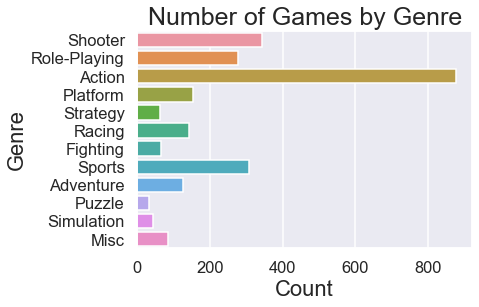

In [47]:
sns.countplot(y ='genre', data = vgsales)
plt.xlabel("Count", size = 22)
plt.ylabel("Genre", size = 22)
plt.title('Number of Games by Genre', size = 25)

Text(0.5, 1.0, 'Number of Games by Platform')

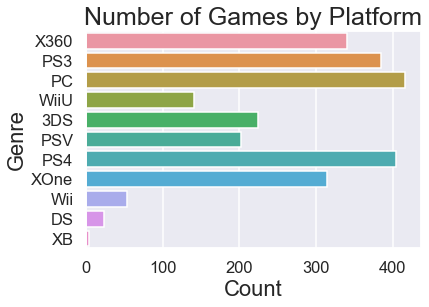

In [48]:
sns.countplot(y ='platform', data = vgsales)
plt.xlabel("Count", size = 22)
plt.ylabel("Genre", size = 22)
plt.title('Number of Games by Platform', size = 25)

From the above two graphs we can see that action gaems make up a large portion of our data set.

Text(0.5, 1.0, 'Number of Sales Comparison Between NA, EU, JP, Other Regions')

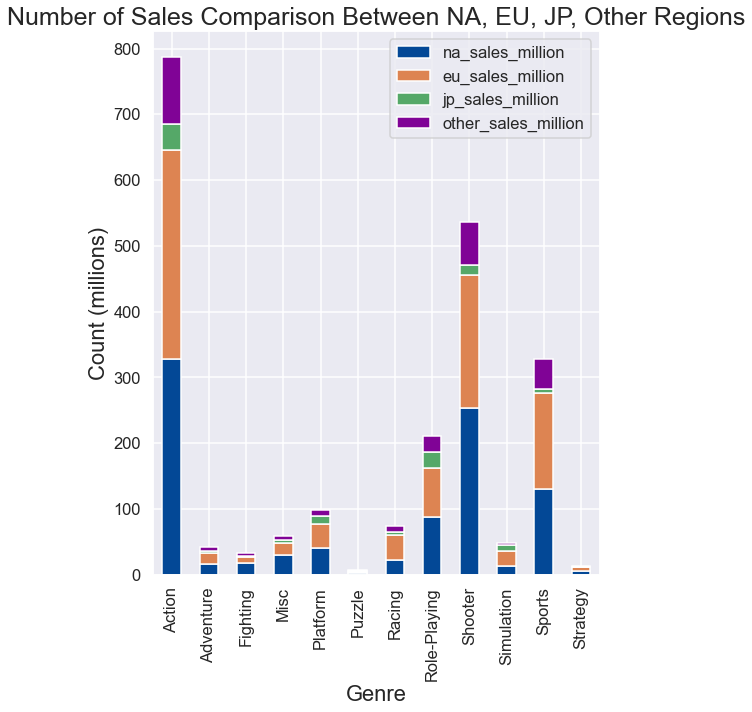

In [64]:
salesD = sales.groupby(['genre']).sum()
region = sales['genre'].unique()
salesD = salesD.drop(columns = ['global_sales_million', 'user_score', 'metascore', 'rank'])
ax = salesD.plot.bar(stacked=True, color = ['#034896', "#dd8452", "#55a868", '#800396'])
fig = plt.gcf()
fig.set_size_inches(8,10)
plt.xlabel("Genre", size = 22)
plt.ylabel("Count (millions)", size = 22)
plt.title('Number of Sales Comparison Between NA, EU, JP, Other Regions', size = 25)

Text(0, 0.5, 'Count')

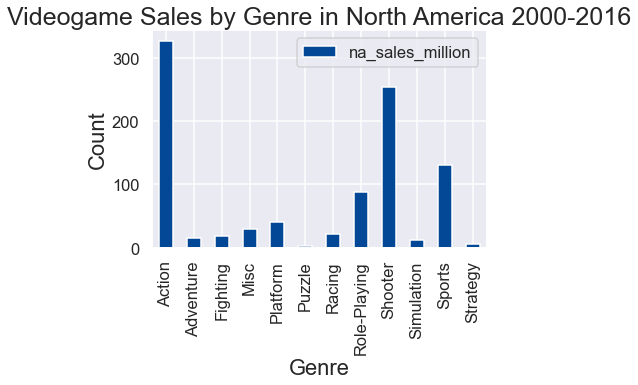

In [63]:
salesD = sales.groupby(['genre']).sum()
na = salesD.plot.bar(y = ['na_sales_million'], color = "#034896")
plt.title('Videogame Sales by Genre in North America 2000-2016', size = 25)
plt.xlabel("Genre", size = 22)
plt.ylabel("Count", size = 22)

Text(0, 0.5, 'Count')

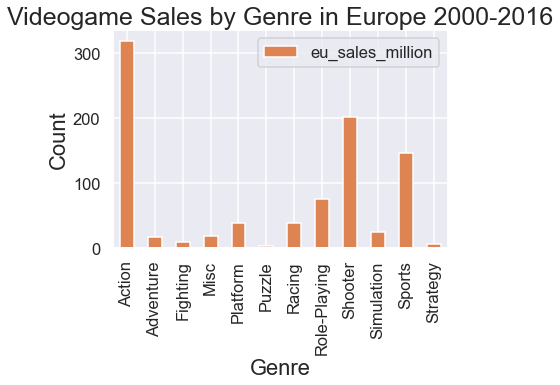

In [31]:
eu = salesD.plot.bar(y = ['eu_sales_million'], color="#dd8452")
plt.title('Videogame Sales by Genre in Europe 2000-2016', size = 25)
plt.xlabel("Genre", size = 22)
plt.ylabel("Count", size = 22)

North America and Europe produce the most sales of all the regions, and we can see that action games contribute a big portion to the total sales.

Text(0, 0.5, 'Count')

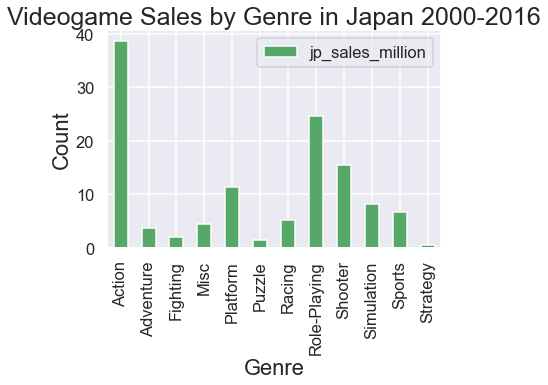

In [32]:
jp = salesD.plot.bar(y = ['jp_sales_million'], color="#55a868")
plt.title('Videogame Sales by Genre in Japan 2000-2016', size = 25)
plt.xlabel("Genre", size = 22)
plt.ylabel("Count", size = 22)

Though Japan makes up a smaller portion of videogame sales globally, role playing games have the highest sales, rather than shooter, sports, and action games which have higher sales in other regions.

Text(0, 0.5, 'Metascore')

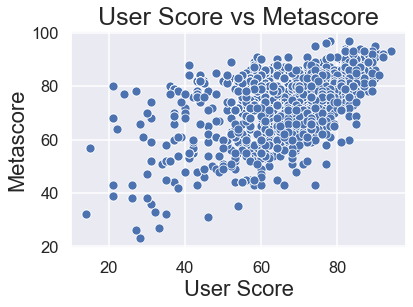

In [34]:
sns.scatterplot(data=vgsales, x="user_score", y="metascore")
plt.title('User Score vs Metascore', size = 25)
plt.xlabel("User Score", size = 22)
plt.ylabel("Metascore", size = 22)

Text(0, 0.5, 'Metascore')

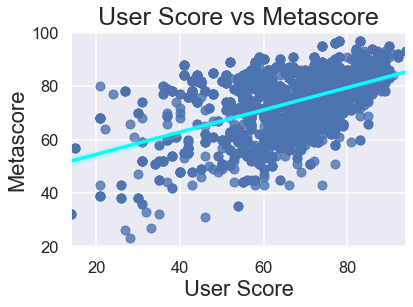

In [33]:
sns.regplot(data=vgsales, x="user_score", y="metascore",line_kws={"color": "cyan"})
plt.title('User Score vs Metascore', size = 25)
plt.xlabel("User Score", size = 22)
plt.ylabel("Metascore", size = 22)

According to the graph, critic scores seem to be correlated with user scores, indicating that user score is correlated with metascore. User score is the average score given by users for a game, and metascore is the average critic score given by critics from metacritic.com.

Text(0, 0.5, 'Global Sales (millions)')

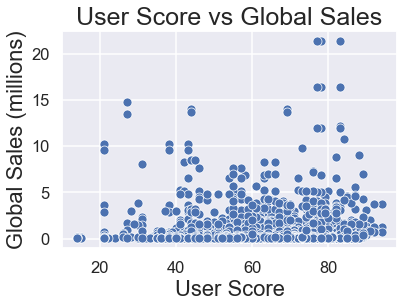

In [36]:
sns.scatterplot(data=vgsales, x="user_score", y="global_sales_million")
plt.title('User Score vs Global Sales', size = 25)
plt.xlabel("User Score", size = 22)
plt.ylabel("Global Sales (millions)", size = 22)

Text(0, 0.5, 'Metascore')

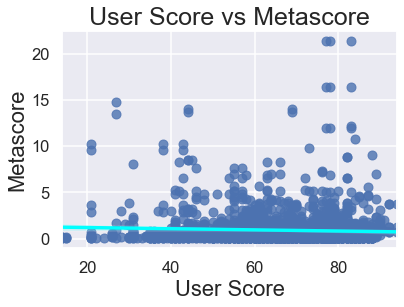

In [35]:
sns.regplot(data=vgsales, x="user_score", y="global_sales_million",line_kws={"color": "cyan"})
plt.title('User Score vs Metascore', size = 25)
plt.xlabel("User Score", size = 22)
plt.ylabel("Metascore", size = 22)

However, if we compare user score to total sales, there is little correlation. Some games that were given a really high user score did not have as much success as those games that have a lower score, and vice versa. The highest grossing games in this set have a score of about 82. People seem to still buy games even if they are rated poorly, and there are quit a few games that users gave high scores to, that did not sell so well.

Text(0, 0.5, 'Global Sales (millions)')

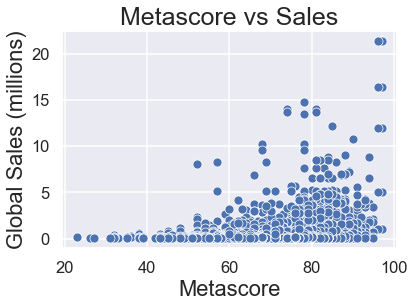

In [38]:
sns.scatterplot(data=vgsales, x="metascore", y="global_sales_million")
plt.title('Metascore vs Sales', size = 25)
plt.xlabel("Metascore", size = 22)
plt.ylabel("Global Sales (millions)", size = 22)

Text(0, 0.5, 'Global Sales (millions)')

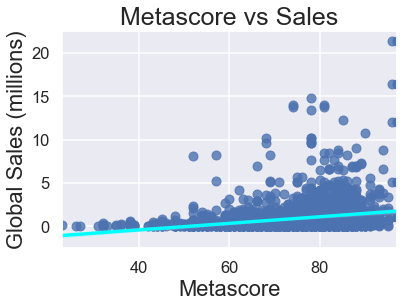

In [37]:
sns.regplot(data=vgsales, x="metascore", y="global_sales_million",line_kws={"color": "cyan"})
plt.title('Metascore vs Sales', size = 25)
plt.xlabel("Metascore", size = 22)
plt.ylabel("Global Sales (millions)", size = 22)

In this case, there is a little more correlation between critic score and sales than the previous graph, which may suggest that critic score can influence how well a game sells.

In [39]:
s = sales.loc[:, ['genre', 'global_sales_million']]
s['rank'] = s['global_sales_million'].rank()

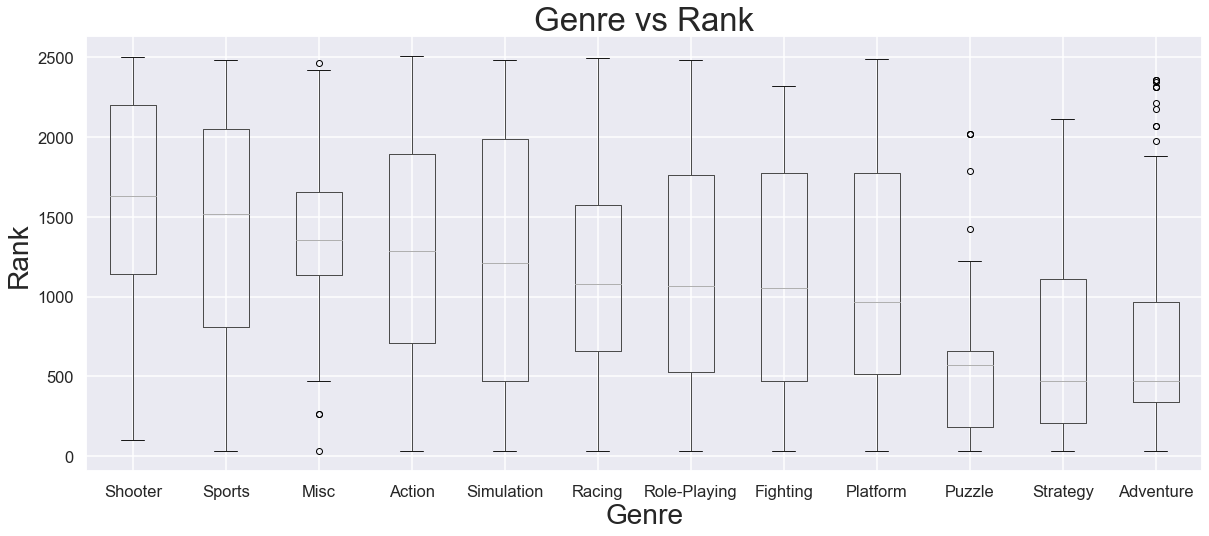

In [56]:
group = s.groupby('genre')
df2 = pd.DataFrame({col:vals['rank'] for col,vals in group})
meds = df2.median()
meds.sort_values(ascending=False, inplace=True)
df2 = df2[meds.index]
df2.boxplot(figsize=(20,8))
plt.title('Genre vs Rank', size = 33)
plt.xlabel("Genre", size = 28)
plt.ylabel("Rank", size = 28)
plt.show()

In the above boxplot, the higher the rank value on the y-axis, the better the sales. The above boxplot suggests that a shooter game tends to be higher ranked in terms of sales. The boxplot also shows several outliers in genres such as adventure. This suggests that while there are some adventure games that are highly ranked in sales, the genre as a whole does not do well in sales. However, because the medians of these genres are dissimilar, the boxplot suggests that genre does affect the sales of a game.

# Analysis (ML Model)

We proceed to build a model based on `user_score`, `metascore`, and `genre`. We are trying to predict `popular`, which is defined by the ranking of `global_sales_million`.

In [41]:
def train_SVM(X, y, kernel='linear'):
    clf = SVC(kernel = kernel)
    clf.fit(X,y)
    return clf
genre_encode.columns

Index(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy'],
      dtype='object')

Train data. To avoid bias towards popular games, we will shuffle the data:

In [42]:
vgsales_shuffled = vgsales.sample(frac=1)
y = vgsales_shuffled['popular'].to_numpy()
x = vgsales_shuffled[['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy', 'metascore', 'user_score']]
train_x = x.iloc[0:2007]
train_x = train_x.to_numpy()
train_y = y[:2007]
test_y = y[2007:]
test_x = x.iloc[2007:]
test_x = test_x.to_numpy()
clf = train_SVM(train_x,train_y)

Predict on train and test datasets.

In [43]:
predict_train_y = clf.predict(train_x)
predict_test_y = clf.predict(test_x)

In [44]:
print(classification_report(test_y, predict_test_y))

              precision    recall  f1-score   support

           0       0.65      0.61      0.63       231
           1       0.68      0.72      0.70       271

    accuracy                           0.67       502
   macro avg       0.66      0.66      0.66       502
weighted avg       0.67      0.67      0.67       502



The classification report tells us that our model is approximately 66-70% accurate, or it is correct approximately 2/3rd of the time. Scores for precision are approximately the same, however for recall, the classifiers ability to find what was designated as an unpopular game was slightly lower than for finding popular games. Though the accuracy of the model to predict a popular game based on the criteria from the data was not perfect, it is still at a significant 2/3. Base on the classification report, we can somewhat reliabily predict whether a game is popular base on genre, user score, and critic score. 

# Ethics & Privacy

There are no PII involved with the data(as we are strictly dealing with public data in the gaming industry). The data used in this project are very close to accurate. Data used in this dataset was scraped from a website called vgchartz.com. This website gets their data from Famitsu, a Japanese videogame magazine, and sales data from NPD, which is a reputable private market research company. The critic score dataset contains data scraped from metacritic.com, which are the critic scores for each game directly from their website.
The data we used is public, however the analysis would show how the large companies have games that are more popular, and could benefit the sales of those companies. Because of this, we decided to leave out the names of the developers to not show any bias or provide any benefit.

# Conclusion & Discussion

<h3>Summary of our result and Discussion</h3>

Our project studied the relationship between game genre, critic score and the popularity of a game (based on the number of sales). According to the prediction report, we have a precision around 66% when trying to predict/classify a game's popularity given its genre and critic score. So, the genre and critic score in some way influence a game's popularity. However, this influence is not very strong. There are other factors (maybe combined with genre and critic score) that determine a game's popularity. 

In addition, We hypothesize that games that fall into the adventure and strategy genres tend to have the highest sales (and therefore popularity). However, according to the EDA section, action games have the highest total (global) sales and highest sales across different regions. So, our hypothesis is not very consistent with our exploration.

<h3>Data Limitations</h3>

The limitations of this study is that we are strictly linking the success of a game on the # of sales and the ratings of the users. As a result, it fails to take into account the other predictors of success in a game, such as the nostalgia factor involved with its game franchise driving up sales, the amount of resources that are dedicated towards improving the quality of a game, the workplace conditions surrounding the development of a game, and so forth. Furthermore, it also fails to account for reviews from organizations like IGN, which is also known for posting reviews, thereby creating a bias towards Metacritic users and critics. Finally, because there are significant amounts of missing data in games before 2016, we needed to limit the study to games from 2016 onwards, thereby failing to take into account a pattern that may have existed beforehand. All of these factors mentioned here therefore reduces the predictive ability of the study.

<h3>Impacts of Work on Society</h3>

If people were to read this report, they will realize game genre, user score, and critic score matter when purchasing games. For example, action games dominate EU and NA, whcih might not be the case in other regions.

# Team Contributions

Overview: Cary

Background: Everyone

Data Cleaning: Derek, Zhaoge

EDA: Everyone

Analysis: Kyle, Derek

Conclusion & Discussion: Zhaoge, Cary

Ethics & Privacy: Kyle